# Goal

This notebook contains much of the code for preprocessing and model fitting for the new estimators for this project.

More specifically, this notebook has a few goals 
1. Train a propensity model for every player (probability of presence on court)
2. Train models that will predict a target given exposure (presence) and unexposure (absence)
3. Use the above models to produce metrics for every player

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from nba_api.stats.endpoints import CommonAllPlayers 
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.spatial.distance import mahalanobis
from typing import Callable
from dataclasses import dataclass

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

c:\Users\Daniel\.virtualenvs\rapm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing the Data

Before we can begin model training (or any statistics), we need to prepare the data.

Much of this section is preprocessing. While it makes most sense to include this in a 
separate notebook, it was easiest to do it here since I frequently refer to each of the variables.

In [2]:
data: pd.DataFrame             = pd.read_csv('../../data/nba_2223_season_stints.csv', dtype={'game_id': str})
plr_id_to_name: dict[str, str] = pd.read_csv('../../data/nba_2223_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
plr_name_to_id: dict[str, str] = dict((v,k) for k,v in plr_id_to_name.items())
box_scores: pd.DataFrame       = pd.read_csv('../../data/nba_2223_box_stats.csv')
per36_stats: pd.DataFrame      = pd.read_csv('../../data/nba_2223_per36_stats.csv')
design: pd.DataFrame           = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz') \
                                   .drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)

First we handle the box score data. We remove accents from player names, add their IDs, and save it.

In [3]:
import unicodedata

def strip_accents(s):
   '''
   Credit to https://stackoverflow.com/a/518232
   '''
   return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

box_scores['Player']   = box_scores['Player'].apply(strip_accents)
box_scores['PlayerID'] = box_scores['Player'].apply(lambda name: plr_name_to_id[name])

Some players have multiple entries (different teams, different positions, etc). We pool all their data and take the total statistics.

Also merge per 36 minute statistics.

In [4]:
cols_to_keep = per36_stats.columns.difference(box_scores.columns)
box_scores = pd.merge(box_scores, per36_stats[cols_to_keep], left_index=True, right_index=True)

box_scores.drop_duplicates('Player', keep='first', inplace=True) # total is always first
box_scores.reset_index(drop=True, inplace=True)
box_scores.set_index('PlayerID', inplace=True)

The models depend on the strength of each team. We infer the strength of home and away.

Strength is defined as the sum of each player's Ball Per Minute (BPM) score.

In [5]:
# careful with the axes. the player IDs are sorted lexicographically, not numerically
home_indicators = design.replace(-1, 0).sort_index(axis=1)
away_indicators = design.replace(1, 0).mul(-1).sort_index(axis=1)
bpm             = box_scores['BPM'].astype(float)

data['home_strength'] = home_indicators.mul(bpm, axis=1).sum(axis=1)
data['away_strength'] = away_indicators.mul(bpm, axis=1).sum(axis=1)

Now we infer game information. We also filter out stints where the game is decided.

In [6]:
def add_game_features(season_data: pd.DataFrame) -> pd.DataFrame:
    '''
    Given a processed season's data, add features for each stint
    relating to game. Specifically, this adds:

      `pm`                  : Plus minus of the stint (Home - Away).
      `home_score`          : The score of the home team.
      `away_score`          : The score of the away team.
      `end_score_margin`    : The score margin at the end of the stint (Home - Away).
      `start_score_margin`  : The score margin at the start of the stint (Home - Away).
      `start_time_left`     : Time left at the start of the stint.
      `end_time_left`       : Time left at the end of the stint

    Note that `score_margin` and `time_left` may be 
    inaccurate by a few points/minutes for later
    stints due to missing data. This is beyond my control.
    '''
    games = pd.unique(season_data['game_id'])

    list_of_data = []
    for game_id in games:
        game_data: pd.DataFrame = season_data.loc[season_data['game_id'] == game_id].copy()
        game_data['pm']         = game_data['home_points'] - game_data['away_points']

        game_data['home_score']         = game_data['home_points'].cumsum()
        game_data['away_score']         = game_data['away_points'].cumsum()
        game_data['end_score_margin']   = game_data['home_score'] - game_data['away_score']
        game_data['start_score_margin'] = game_data['end_score_margin'].shift(fill_value=0)

        # this is not exactly "time remaining" 
        # since some games have missing stints
        # it's a decent approximation though
        time_elapsed = game_data['minutes'].cumsum()
        game_data['start_time_left'] = 48 - time_elapsed.shift(fill_value=0)
        game_data['end_time_left']   = 48 - time_elapsed
    
        list_of_data.append(game_data)

    return pd.concat(list_of_data)

In [7]:
data = add_game_features(data)

# filter out stints when the game is decided
# drop iff start_time_elapsed >= 36 AND |start_score_margin| >= 20
# keep iff start_time_elapsed < 36 OR |start_score_margin| < 20
ok_stints = (data['start_time_left'] < 36) | (data['start_score_margin'].abs() < 20)
data = data.loc[ok_stints]
design = design.loc[ok_stints]

Finally, infer the total minutes played for each player (done at the end in order to exclude filtered stints)

In [8]:
# this can totally be done in a single mat mul operation
# i'm just too lazy to figure it out
box_scores['Min'] = np.empty(len(box_scores))
for plr_id in box_scores.index:
    box_scores.at[plr_id, 'Min'] = data['minutes'].mul(design[plr_id].abs()).sum()

def get_low_min_plrs(plr_data: pd.DataFrame, *, thresh: float = 48) -> pd.Index:
    '''
    Return every player whose minutes are below a threshold.

    In the given dataset, the index is expected to be the PlayerID.
    '''
    return plr_data.loc[plr_data['Min'] < thresh].index

# Fit the Player Models

All the preprocessing is complete. At this point, we must fit models for every player. The propensity model will be a Random Forest, while the margin models Ridge Regression.

Every player must be trained on stints where they *could* have been present, so filtering the data for each player is necessary. 
Since players can be apart of multiple teams, it is complicated to determine games they could've been a part of, as this requires determining
when the player swapped teams. **As such, the model is only trained on stints in a game where the player was on the court at least once.**

Note that we require each players' total play time to be at least 48 minutes (1 full game). Otherwise, they will not be given a metric or a model. They are not dropped from the dataset in total. (The alternative requires us to drop stints they were present in due to how "strength" and "closeness" is determined.)

In [9]:
# it's necessary to determine games where the player was present at least once
#
# moreover, it's necessary to determine whether the player was on home/away,
# in order to appropriately adjust score margin.
#
# this solution basically replaces the design matrix. instead of being an indicator
# for presence in the stint, it will serve for an indicator of presence in the game.

games = pd.unique(data['game_id'])

plr_indicators_list = []
for game_id in games:
    indicators: pd.DataFrame = design.loc[data['game_id'] == game_id].copy()

    sign = np.sign(indicators.sum(axis=0))

    plr_indicators_list.append(
        indicators.replace(0, {
            plr_id: indic
            for plr_id, indic in zip(indicators.columns, sign)
            if indic != 0
        })
    )

game_presence = pd.concat(plr_indicators_list)

In [10]:
game_presence.head(50)

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

For both the propensity and margin models, we will need to evaluate the player team's strength.

However, this has an issue: sometimes the player is present, other times the player isn't.
- If the player is present, we can just use the other 4 players.
- If the player isn't present, we will have to remove the "closest player"

In the 2nd case, we will determine closeness based on the Mahalonabis distance of the features "POS", "2PA", "3PA", "FTA", "TRB", "AST", "STL", "BLK"

POS will be handled like so:
 - If there is exactly 1 player on court with the same position, consider them closest.
 - If there are none or more, consider Mahalonabis distance for everyone.

In [11]:
DISTANCE_FEATURES = ["2PA", "3PA", "FTA", "TRB", "AST", "STL", "BLK"]
inv_cov = np.linalg.inv(box_scores[DISTANCE_FEATURES].cov())

def determine_closest_player(ref_plr_id: str, plr_list: list[str], *, inv_cov: np.ndarray = inv_cov) -> str:
    '''
    Determine the closest player to the reference player.
    
    If there is only one player whose position is the same
    as the reference player, then this player is returned instead.

    By default, the pre-computed inverse covariance is used. 
    Pass in a different one if this needs to be changed.
    '''
    closest_plr, closest_val = None, np.inf
    same_pos_plr, count = None, 0

    ref_features  = box_scores.loc[ref_plr_id, DISTANCE_FEATURES]
    ref_positions = box_scores.at[ref_plr_id, 'Pos'].split('-')

    for plr_id in plr_list:
        for pos in ref_positions:
            if pos in box_scores.at[plr_id, 'Pos']:
                same_pos_plr = plr_id
                count += 1

        dist = mahalanobis(ref_features, box_scores.loc[plr_id, DISTANCE_FEATURES], VI=inv_cov)
        if dist < closest_val:
            closest_val = dist
            closest_plr = plr_id
    
    return same_pos_plr if count == 1 else closest_plr


In [12]:
import json

# computing the "most alike player" is expensive, so it's cached into a json file
with open('sub_cache.json') as file:
    substitution_cache: dict[str, list[float]] = json.load(file)

def export_cache(sub_dict: dict[str, pd.Series]):
    new_cache = {
        plr: series.to_list()
        for plr, series in sub_dict.items()
    }

    with open('sub_cache.json', 'w') as fp:
        json.dump(new_cache, fp)

def get_features(df: pd.DataFrame, /) -> pd.DataFrame:
  '''
  Return the features used to train the models.

  This is purely for readability.
  '''
  return df.loc[:, ['start_score_margin', 'team_strength', 'opponent_strength']]

def _apply_substitution(row: pd.Series, *, ref_plr: str) -> float:
    '''
    Determines the BPM of the player that will be "substituted"

    To be applied in the 'train' functions.
    '''
    team = 'home' if row['_indicator'] == 1 else 'away'
    return box_scores.at[
       determine_closest_player(ref_plr, row[f'{team}_lineup'].split('_')), 
       'BPM'
    ]

In [13]:
@dataclass(kw_only=True)
class PlayerPropensityModel:
    '''
    A dataclass container for the propensity model.

    ## Attributes
      `plr_id`: The ID of the player.
      `model`: The propensity model.
      `data`: The data used to train the model.
      `targets`: The targets of the corresponding data.
    '''
    plr_id: str
    model: RandomForestClassifier
    data: pd.DataFrame
    target: pd.Series

def train_prop_model(
        plr_id: str, 
        *, 
        bpm_cache: dict[str, list[float]] = substitution_cache,
        season_presence: pd.DataFrame = game_presence, 
        season_design: pd.DataFrame   = design, 
        season_data: pd.DataFrame     = data
    ) -> PlayerPropensityModel:
    '''
    Given a player ID, train a propensity model. 
    This is trained on the features `['start_score_margin', 'team_strength', 'opponent_strength']` in that order.
    All stints are weighted by their number of possessions.

    ## Parameters

      `plr_id`: The player to train the model on.

      `cache`: A cache containing the substituted BPM values for every player.
      This is a rather costly operation, so it's preferred to save this cache.
      This is the global variable `substitution_cache` by default.

      `season_presence` : Indicators for presence in a game.
      Namely: 1 if player was present on Home, -1 if present on away, 0 if absent.
      This marks games containing stints the player could have been in.
      This is the global variable `game_precense` by default.
      
      `season_design`   : Indicators for presence in a stint. Standard RAPM design matrix.
      This is the global variable `design` by default.

      `season_data`     : Processed season data. This is the global variable `data` by default.

    ## Returns
    
    Returns a dataclass. See `PlayerPropensityModel`.
    '''
    # identify relevent stints
    bools: pd.Series[bool]  = season_presence.loc[:, plr_id].astype(bool)
    plr_data                = season_data.loc[bools].copy()
    plr_game_presence       = season_presence.loc[bools, plr_id].copy()

    # change the score margin to the perspective of the player
    plr_data.loc[:, 'start_score_margin'] *= plr_game_presence

    # identify opponent strength
    home_is_opponent = plr_game_presence.replace(1, 0).abs() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = plr_game_presence.replace(-1, 0)      # away is opponent if indicator is 1. filter out -1.
    plr_data.loc[:, 'opponent_strength'] = plr_data.loc[:, 'home_strength'] * home_is_opponent + plr_data.loc[:, 'away_strength'] * away_is_opponent # only one of these is non-zero

    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data.loc[:, '_indicator'] = plr_game_presence # indicates which team the player is on. for use in `_apply_substitution`

    if plr_id not in bpm_cache:
      bpm_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = bpm_cache[plr_id]
    plr_data.loc[:, 'team_strength'] = plr_data.loc[:, 'home_strength'] * home_is_team + plr_data.loc[:, 'away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # extract target: 1 if on court, 0 otherwise.
    target = season_design.loc[bools, plr_id].abs()

    # train the model.
    model = RandomForestClassifier().fit(X=plr_data[['start_score_margin', 'team_strength', 'opponent_strength']], y=target, sample_weight=plr_data.loc[:, 'n_pos'])

    return PlayerPropensityModel(
       plr_id=plr_id,
       model=model, 
       data=plr_data.drop('_indicator', axis=1), 
       target=target
    )

In [14]:
@dataclass(kw_only=True)
class PlayerLinearMarginModel:
    '''
    A dataclass container for the linear (ridge) margin models.

    ## Attributes

    ### Primary Attributes

      `plr_id`          : The ID of the player.
      `exposed_model`   : The model predicting margin (assuming player presence).
      `unexposed_model` : The model predicting margin (assuming player absence).
      `exposed_data`    : The training data for the exposed model.
      `unexposed_data`  : The training data for the unexposed model
      `exposed_target`  : The target for the exposed model.
      `unexposed_target`: The target for the unexposed model.

    ### Secondary Attributes

      `data`            : The combined data for both models.
      `target`          : The combined targets for both models.
      `exposed_bools`   : A list of bools corresponding to indices of exposed data.   (For use in pandas indexing)
      `unexposed_bools` : A list of bools corresponding to indices of unexposed data. (For use in pandas indexing)
    '''
    plr_id: str
    exposed_model: RidgeCV
    unexposed_model: RidgeCV
    data: pd.DataFrame
    target: pd.Series
    exposed_bools: pd.Series
    unexposed_bools: pd.Series

    @property
    def exposed_data(self):
       return self.data.loc[self.exposed_bools]
    
    @property
    def unexposed_data(self):
       return self.data.loc[self.unexposed_bools]
    
    @property
    def exposed_target(self):
       return self.target[self.exposed_bools]
    
    @property
    def exposed_target(self):
       return self.target[self.unexposed_bools]

def train_linear_margin_model(
        plr_id: str, 
        *, 
        hypers: list[float] = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000],
        default_hyper: float = 50,
        scoring: str | Callable = 'neg_root_mean_squared_error',
        bpm_cache: dict[str, list[float]] = substitution_cache,
        season_presence: pd.DataFrame = game_presence, 
        season_design: pd.DataFrame   = design, 
        season_data: pd.DataFrame     = data
    ) -> PlayerLinearMarginModel:
    '''
    Trains two models predicting margin (points per 100 possessions) of a stint.
    The first predicts the margin given the presence of the player.
    The second predicts the margin given the absence of the player.
    This is meant to be used in the doubly-robust estimator.

    ## Model Training
    The models will be trained using Ridge regression 
    with Leave-One-Out cross-validation. 
    The features are the same for the propensity model, namely:
    `['start_score_margin', 'team_strength', 'opponent_strength']`
    
    All stints are weighted by their number of possessions.

    The first model will only be trained on stints where 
    the player was present, and the second will only be trained
    on stints where the player was absent (in games where they were present at least once).
    
    ## Parameters
      `hypers`          : A list of hyperparameters to be used in the cross-validation.
      `default_hyper`   : Some players are only present for a single stint, so cross-validation can't be performed. Standard ridge with this hyperparameter is used instead.
      `scoring`         : The scorer used in cross-validation. See scikit-learn documentation. RMSE by default.
    
`cache`: A cache containing the substituted BPM values for every player.
      This is a rather costly operation, so it's preferred to save this cache.
      This is the global variable `substitution_cache` by default.

      `season_presence` : Indicators for presence in a game.
      Namely: 1 if player was present on Home, -1 if present on away, 0 if absent.
      This marks games containing stints the player could have been in.
      This is the global variable `game_precense` by default.
      
      `season_design`   : Indicators for presence in a stint. Standard RAPM design matrix.
      This is the global variable `design` by default.

      `season_data`     : Processed season data. This is the global variable `data` by default.
    '''
    bools         = season_presence.loc[:, plr_id].astype(bool)
    plr_data      = season_data.loc[bools].copy()
    plr_presence  = season_presence.loc[bools, plr_id].copy()
    indic         = season_design.loc[bools].copy()

    # change the score margin and margin to the perspective of the player
    plr_data.loc[:, 'start_score_margin'] *= plr_presence
    plr_data.loc[:, 'margin'] *= plr_presence

    # identify opponent strength
    home_is_opponent = plr_presence.replace(1, 0).abs() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = plr_presence.replace(-1, 0)      # away is opponent if indicator is 1. filter out -1.
    plr_data.loc[:, 'opponent_strength'] = plr_data.loc[:, 'home_strength'] * home_is_opponent + plr_data.loc[:, 'away_strength'] * away_is_opponent # only one of these is non-zero
    
    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data.loc[:, '_indicator'] = plr_presence # indicates which team the player is on 

    if plr_id not in bpm_cache:
      bpm_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = bpm_cache[plr_id]
    plr_data.loc[:, 'team_strength'] = plr_data.loc[:, 'home_strength'] * home_is_team + plr_data.loc[:, 'away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # "exposure" refers to presence of the player.
    # a stint is exposed if the player is present, unexposed otherwise
    exposed_bools   = indic[plr_id].astype(bool)
    unexposed_bools = ~exposed_bools

    # unexposed model
    unexposed_target  = plr_data.loc[unexposed_bools, 'margin']
    unexposed_input   = plr_data.loc[unexposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(unexposed_input) > 1:
      unexposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(unexposed_input, unexposed_target, sample_weight=plr_data.loc[unexposed_bools, 'n_pos']) 
    else:
      unexposed_model = Ridge(alpha=default_hyper).fit(unexposed_input, unexposed_target)
      unexposed_model.best_score_ = rmse(unexposed_target, unexposed_model.predict(unexposed_input))

    # exposed model
    exposed_target  = plr_data.loc[exposed_bools, 'margin']
    exposed_input   = plr_data.loc[exposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(exposed_input) > 1:
      exposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(exposed_input, exposed_target, sample_weight=plr_data.loc[exposed_bools, 'n_pos'])
    else: 
      exposed_model = Ridge(alpha=default_hyper, scoring=scoring).fit(exposed_input, exposed_target)
      exposed_model.best_score_ = rmse(exposed_target, exposed_model.predict(exposed_input))

    return PlayerLinearMarginModel(
       plr_id=plr_id,
       exposed_model=exposed_model,
       unexposed_model=unexposed_model,
       data=plr_data,
       target=plr_data.loc[:, 'margin'],
       exposed_bools=exposed_bools,
       unexposed_bools=unexposed_bools
    )

In [15]:
@dataclass(kw_only=True)
class PlayerForestMarginModel:
    '''
    A dataclass container for the random forest margin models.

    ## Attributes

    ### Primary Attributes

      `plr_id`          : The ID of the player.
      `exposed_model`   : The model predicting margin (assuming player presence).
      `unexposed_model` : The model predicting margin (assuming player absence).
      `exposed_data`    : The training data for the exposed model.
      `unexposed_data`  : The training data for the unexposed model
      `exposed_target`  : The target for the exposed model.
      `unexposed_target`: The target for the unexposed model.

    ### Secondary Attributes

      `data`            : The combined data for both models.
      `target`          : The combined targets for both models.
      `exposed_bools`   : A list of bools corresponding to indices of exposed data.   (For use in pandas indexing)
      `unexposed_bools` : A list of bools corresponding to indices of unexposed data. (For use in pandas indexing)
    '''
    plr_id: str
    exposed_model: RandomForestRegressor
    unexposed_model: RandomForestRegressor
    data: pd.DataFrame
    target: pd.Series
    exposed_bools: pd.Series
    unexposed_bools: pd.Series

    @property
    def exposed_data(self):
       return self.data.loc[self.exposed_bools]
    
    @property
    def unexposed_data(self):
       return self.data.loc[self.unexposed_bools]
    
    @property
    def exposed_target(self):
       return self.target[self.exposed_bools]
    
    @property
    def exposed_target(self):
       return self.target[self.unexposed_bools]

def train_forest_margin_model(
        plr_id: str, 
        *, 
        bpm_cache: dict[str, list[float]] = substitution_cache,
        season_presence: pd.DataFrame = game_presence, 
        season_design: pd.DataFrame   = design, 
        season_data: pd.DataFrame     = data
    ) -> PlayerForestMarginModel:
    '''
    Trains two models predicting margin (points per 100 possessions) of a stint.
    The first predicts the margin given the presence of the player.
    The second predicts the margin given the absence of the player.
    This is meant to be used in the doubly-robust estimator.

    ## Model Training
    The models will be trained using Random Forest Regression. 
    The features are the same for the propensity model, namely:
    `['start_score_margin', 'team_strength', 'opponent_strength']`
    
    All stints are weighted by their number of possessions.

    The first model will only be trained on stints where 
    the player was present, and the second will only be trained
    on stints where the player was absent (in games where they were present at least once).
    
    ## Parameters
      `hypers`          : A list of hyperparameters to be used in the cross-validation.
      `default_hyper`   : Some players are only present for a single stint, so cross-validation can't be performed. Standard ridge with this hyperparameter is used instead.
      `scoring`         : The scorer used in cross-validation. See scikit-learn documentation. RMSE by default.
    
`cache`: A cache containing the substituted BPM values for every player.
      This is a rather costly operation, so it's preferred to save this cache.
      This is the global variable `substitution_cache` by default.

      `season_presence` : Indicators for presence in a game.
      Namely: 1 if player was present on Home, -1 if present on away, 0 if absent.
      This marks games containing stints the player could have been in.
      This is the global variable `game_precense` by default.
      
      `season_design`   : Indicators for presence in a stint. Standard RAPM design matrix.
      This is the global variable `design` by default.

      `season_data`     : Processed season data. This is the global variable `data` by default.
    '''
    bools         = season_presence.loc[:, plr_id].astype(bool)
    plr_data      = season_data.loc[bools].copy()
    plr_presence  = season_presence.loc[bools, plr_id].copy()
    indic         = season_design.loc[bools].copy()

    # change the score margin and margin to the perspective of the player
    plr_data.loc[:, 'start_score_margin'] *= plr_presence
    plr_data.loc[:, 'margin'] *= plr_presence

    # identify opponent strength
    home_is_opponent = plr_presence.replace(1, 0).abs() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = plr_presence.replace(-1, 0)      # away is opponent if indicator is 1. filter out -1.
    plr_data.loc[:, 'opponent_strength'] = plr_data.loc[:, 'home_strength'] * home_is_opponent + plr_data.loc[:, 'away_strength'] * away_is_opponent # only one of these is non-zero
    
    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data.loc[:, '_indicator'] = plr_presence # indicates which team the player is on 

    if plr_id not in bpm_cache:
      bpm_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = bpm_cache[plr_id]
    plr_data.loc[:, 'team_strength'] = plr_data.loc[:, 'home_strength'] * home_is_team + plr_data.loc[:, 'away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # "exposure" refers to presence of the player.
    # a stint is exposed if the player is present, unexposed otherwise
    exposed_bools   = indic[plr_id].astype(bool)
    unexposed_bools = ~exposed_bools

    # unexposed model
    unexposed_target  = plr_data.loc[unexposed_bools, 'margin']
    unexposed_input   = plr_data.loc[unexposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    unexposed_model   = RandomForestRegressor().fit(unexposed_input, unexposed_target, sample_weight=plr_data.loc[unexposed_bools, 'n_pos']) 

    # exposed model
    exposed_target  = plr_data.loc[exposed_bools, 'margin']
    exposed_input   = plr_data.loc[exposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    exposed_model   = RandomForestRegressor().fit(exposed_input, exposed_target, sample_weight=plr_data.loc[exposed_bools, 'n_pos'])

    return PlayerForestMarginModel(
       plr_id=plr_id,
       exposed_model=exposed_model,
       unexposed_model=unexposed_model,
       data=plr_data,
       target=plr_data.loc[:, 'margin'],
       exposed_bools=exposed_bools,
       unexposed_bools=unexposed_bools
    )

In [16]:
prob_models: dict[str, PlayerPropensityModel] = {
    plr_id: train_prop_model(plr_id)
    for plr_id in plr_id_to_name
    if box_scores.at[plr_id, 'Min'] >= 48
}

In [17]:
linear_margin_models: dict[str, PlayerLinearMarginModel] = {
    plr_id: train_linear_margin_model(plr_id)
    for plr_id in plr_id_to_name
    if box_scores.at[plr_id, 'Min'] >= 48
}

In [18]:
forest_margin_models: dict[str, PlayerForestMarginModel] = {
    plr_id: train_forest_margin_model(plr_id)
    for plr_id in plr_id_to_name
    if box_scores.at[plr_id, 'Min'] >= 48
}

# Extract Results

Now that all the propensity models are trained, we can extract information from them.

In [19]:
# probs: dict[str, tuple[np.ndarray, float]] = { # probability that player is on court for their stint (not all stints are the same across players!) and accuracy of model
#     plr_id: (
#         container.model.predict_proba(get_features(container.data))[:, 1], 
#         container.model.score(get_features(container.data), container.target)
#     )
#     for plr_id, container in prob_models.items()
# }

In [20]:
def summarize(arr, label=''):
    '''
    Print summary statistics of given array.
    Label is printed first.
    '''
    print(
        label,
        f'Average: {np.mean(arr)}',
        f'Median: {np.median(arr)}',
        f'St. Dev.: {np.std(arr)}',
        f'Min: {np.min(arr)}',
        f'Max: {np.max(arr)}',
        sep='\n'
    )

accuracies          = [
    container.model.score(get_features(container.data), container.target, sample_weight=container.data['n_pos']) 
    for container in prob_models.values()
]
linear_rmses_exp    = [
    rmse(container.exposed_model.predict(get_features(container.data)), container.target, sample_weight=container.data['n_pos']) 
    for container in linear_margin_models.values()
]
linear_rmses_unexp = [
    rmse(container.unexposed_model.predict(get_features(container.data)), container.target, sample_weight=container.data['n_pos']) 
    for container in linear_margin_models.values()
]
forest_rmses_exp    = [
    rmse(container.exposed_model.predict(get_features(container.data)), container.target, sample_weight=container.data['n_pos']) 
    for container in forest_margin_models.values()
]
forest_rmses_unexp = [
    rmse(container.unexposed_model.predict(get_features(container.data)), container.target, sample_weight=container.data['n_pos']) 
    for container in forest_margin_models.values()
]

summarize(accuracies, '\nPropensity Accuracy')
summarize(linear_rmses_exp, '\nLinear RMSE: Exposed')
summarize(linear_rmses_unexp, '\nLinear RMSE: Unexposed')
summarize(forest_rmses_exp, '\nForest RMSE: Exposed')
summarize(forest_rmses_unexp, '\nForest RMSE: Unexposed')


Propensity Accuracy
Average: 0.997715953676211
Median: 0.998105819783861
St. Dev.: 0.0020417717848201485
Min: 0.988171235448742
Max: 1.0

Linear RMSE: Exposed
Average: 45.632481400927524
Median: 45.565379364127935
St. Dev.: 2.0269136770300467
Min: 37.49850137594549
Max: 69.48752861563378

Linear RMSE: Unexposed
Average: 45.35344320903847
Median: 45.34788367547833
St. Dev.: 1.5893312781259874
Min: 37.27583842145714
Max: 50.70600597559584

Forest RMSE: Exposed
Average: 42.909654085717094
Median: 42.41298213925445
St. Dev.: 6.499582262014057
Min: 29.546659933869886
Max: 70.70683859928941

Forest RMSE: Unexposed
Average: 38.15536287318519
Median: 38.568421408782314
St. Dev.: 6.469649620818051
Min: 22.73219428971451
Max: 58.46156546342478


C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\3510550543.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


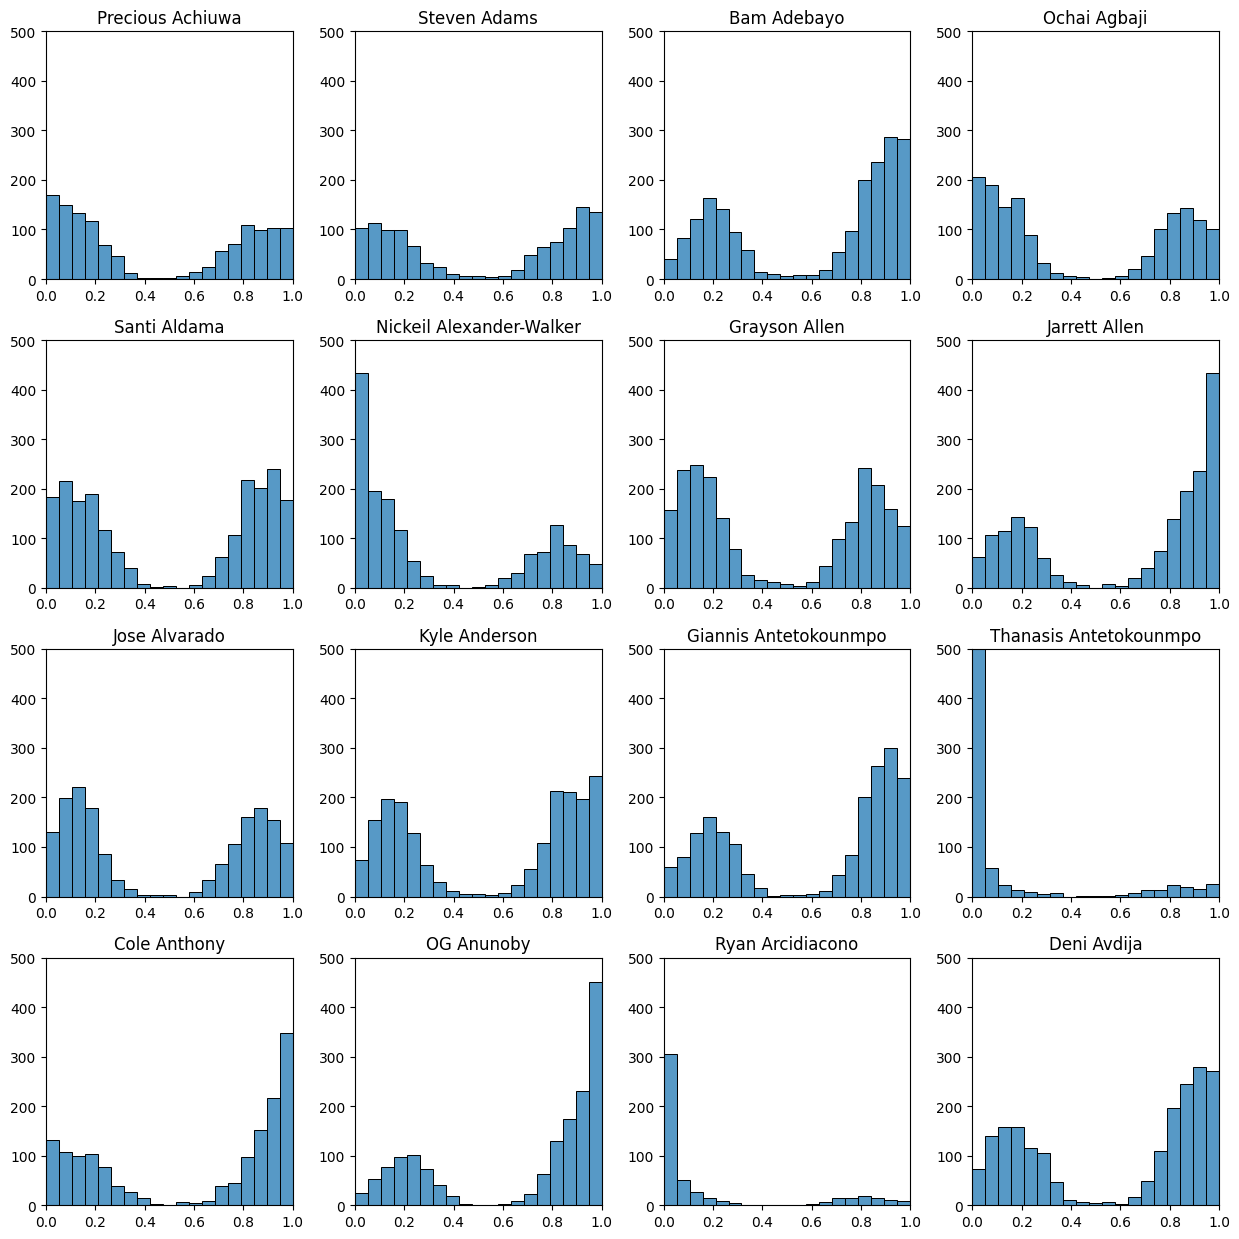

In [21]:
# make a collage
n = 4

fig, ax = plt.subplots(n,n, figsize=(12.5, 12.5))

plr_ids = list(prob_models)

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id = plr_ids[k]
    plr_prob = prob_models[plr_id].model.predict_proba(get_features(prob_models[plr_id].data))[:, 1]

    graph = sns.histplot(plr_prob, bins=np.linspace(0, 1, 20), ax=ax[i, j])
    graph.set_xlim(0, 1)
    graph.set_ylim(0, 500)
    graph.set_ylabel('')
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()

# Compute Weighted Estimators

Now that we have propensity scores, we will use them for a few estimators of skill. Here, $\mu$ represents player skill.

Note that margin is defined as $\frac{\text{PM}}{\text{No. of Possesstions}} * 100$

Define
- $p_i$ = Propensity score of stint $i$ (i.e. probability of presence)
- $t_i$ = 0 if absent, 1 if present
- $y_i$ = The margin of the stint (in the eyes of the player)
- $n_i$ = Number of possessions in the stint

## Inverse-Propensity Weighting

The IPW estimator is given by

$$
    \mu_{\text{ipw}} = \dfrac{\sum y_i \cdot n_i (t_i p_{i}^{-1} - (1 - t_i) (1 - p_i)^{-1})}{\sum n_i}
$$

While this looks complicated, this is reweighting the stints, where the weight is $\frac{1}{p_i}$ if the player was present, and $\frac{1}{1 - p_i}$ if the player wasn't present. In other words, each stint is weighted by the inverse of the probability of being correct.

Note that instead of computing this on the stint-level, we compute this on the possession-level. Hence, stints are weighted by number of possessions, and divided by sum of possessions.


## Overlapping Weights

The overlapping estimator is given by
$$
\mu_{\text{overlap}} = \dfrac{\sum y_i \cdot n_i [t_i (1 - p_i) - (1 - t_i) p_i]}{\sum n_i}
$$

Essentially, where IPW assigned weights based on the probability of being correct, overlapping weights assign weights based on the probability of being incorrect. This mainly upweights stints that can be in either treatment group (i.e. it upweights stints that could either have a player's presence, or could lack a player's presence).

# Compute DR Estimators

Using both the propensity and margin models, we can compute the doubly-robust estimators for each player. 

Let $i$ be a stint. Define
- $y_i$ - True margin of stint $i$.
- $\hat{y}_{i}^{(0)}$ - Predicted margin, given absence of player.
- $\hat{y}_{i}^{(1)}$ - Predicted margin, given presence of player.
- $p_i$ - Propensity score of stint (i.e. probability of player presence)
- $t_i$ - Indicator of player presence. 0 = Absent, 1 = Present.
- $n_i$ - Number of possessions in the stint.

Note that the margins are in the eyes of the player.

## IPW-DR Estimator

Then the doubly robust estimators are defined as
$$
    \begin{align*}
        \text{IPW-DR}_1 &= \dfrac{\sum n_i \left[ \hat{y}_{i}^{(1)} + (y_i - \hat{y}_{i}^{(1)}) \cdot \frac{t_i}{p_i} \right]}{\sum n_i} \\
        \text{IPW-DR}_0 &= \dfrac{\sum n_i \left[ \hat{y}_{i}^{(0)} + (y_i - \hat{y}_{i}^{(0)}) \cdot \frac{1 - t_i}{1 - p_i} \right]}{\sum n_i} \\
    \end{align*}
$$

Where $\text{DR}_0$ is the expected margin under absence, and $\text{DR}_1$ is the expected margin under presence. The player's effect is this $\mu_{\text{IPW-DR}} = \text{DR}_1 - \text{DR}_0$

This is essentially a weighted average of true margins subtracted by standardized residuals, where the residuals are weighted by the inverse propensities.

## Overlap-DR Estimator

Using the same definition as above, we have
$$
    \begin{align*}
        \text{O-DR}_1 &= \dfrac{\sum n_i \left[ \hat{y}_{i}^{(1)} + (y_i - \hat{y}_{i}^{(1)}) \cdot t_i (1 - p_i) \right]}{\sum n_i} \\
        \text{O-DR}_0 &= \dfrac{\sum n_i \left[ \hat{y}_{i}^{(0)} + (y_i - \hat{y}_{i}^{(0)}) \cdot (1 - t_i) p_i \right]}{\sum n_i} \\
    \end{align*}
$$

Then $\mu_{\text{O-DR}} = \text{O-DR}_1 - \text{O-DR}_0$

# Division by Zero

To prevent divisions by 0 in the estimators, $p_i$ is constrainted to be between $[\epsilon, 1-\epsilon]$ for some $\epsilon > 0$. This is carried over for the overlapping estimator for consistency. We use $\epsilon = 0.001$

In [40]:
eps = 1e-3 # probability threshold

COMPUTE_ATE = False
# if true, compute ATE. this means considering all stints
# if false, compute ATT. this means considering only stints the player was present in.

USE_LINEAR_MODEL = False
# if true, use the linear margin models for margin predictions
# if false, use the forest margin models

WEIGHT_BY_POSSESSION = True 
# if true, weight each stint by n_pos and divide by sum of n_pos (so compute weighted average using n_pos)
# if false, use original weights (so compute regular average)

results = pd.read_csv('../../results/ryurko_results.csv', index_col='Player ID', dtype={'Player ID': str})
results[['IPW Effect', 'Overlap Effect', 'IPW-DR Effect', 'Overlap-DR Effect', 'Predicted Effect']] = pd.DataFrame(
    data=np.zeros((len(results), 5), dtype=np.float64),
    index=results.index
)
results['Minutes'] = box_scores.loc[results.index, 'Min']

def normalize(arr: np.ndarray, /) -> np.ndarray:
    return arr / arr.sum()

for plr_id, container in prob_models.items():
    plr_data        = container.data
    presence_probs  = container.model.predict_proba(get_features(plr_data))[:, 1] # the order of these probabilities matches the order of the player's game data
    margin          = plr_data['margin'] * game_presence.loc[plr_data.index, plr_id] # get margin in the eyes of the player
    true_presence   = design.loc[plr_data.index, plr_id].abs()

    # grab the right predictions
    if USE_LINEAR_MODEL:
        exposed_marg    = linear_margin_models[plr_id].exposed_model.predict(get_features(plr_data))
        unexposed_marg  = linear_margin_models[plr_id].unexposed_model.predict(get_features(plr_data))
    else:
        exposed_marg    = forest_margin_models[plr_id].exposed_model.predict(get_features(plr_data))
        unexposed_marg  = forest_margin_models[plr_id].unexposed_model.predict(get_features(plr_data))

    # filter out absent stints if ATT is desired
    if not COMPUTE_ATE:
        att_stints = true_presence.astype(bool).values
        plr_data = plr_data.loc[att_stints]
        presence_probs = presence_probs[att_stints]
        margin = margin.loc[att_stints]
        true_presence = true_presence.loc[att_stints]
        exposed_marg = exposed_marg[att_stints]
        unexposed_marg = unexposed_marg[att_stints]

    # to reduce the number of if statements 
    n_pos = plr_data['n_pos'] if WEIGHT_BY_POSSESSION else np.ones(len(plr_data['n_pos'])) 
    N = n_pos.sum() # this is repeatedly called

    # filter out extreme values
    presence_probs[presence_probs < eps] = eps
    presence_probs[presence_probs > 1 - eps] = 1 - eps

    # IPW Effect
    ipw_exposed_weights     = true_presence / presence_probs
    ipw_unexposed_weights   = (1 - true_presence) / (1 - presence_probs)

    results.at[plr_id, 'IPW Effect'] = np.dot(n_pos * margin, ipw_exposed_weights - ipw_unexposed_weights) / N

    # Overlap Effect
    overlap_exposed_weights     = true_presence * (1 - presence_probs)
    overlap_unexposed_weights   = (1 - true_presence) * presence_probs

    results.at[plr_id, 'Overlap Effect'] = np.dot(n_pos * margin, overlap_exposed_weights - overlap_unexposed_weights) / N
    
    ### DR Effect
    
    # IPW-DR Effect
    ipw_dr1 = np.dot(n_pos, exposed_marg + (margin - exposed_marg) * ipw_exposed_weights) / N
    ipw_dr0 = np.dot(n_pos, unexposed_marg + (margin - unexposed_marg) * ipw_unexposed_weights) / N

    results.at[plr_id, 'IPW-DR Effect'] = ipw_dr1 - ipw_dr0

    # Overlap-DR Effect
    odr1 = np.dot(n_pos, exposed_marg + (margin - exposed_marg) * overlap_exposed_weights) / N
    odr0 = np.dot(n_pos, unexposed_marg + (margin - unexposed_marg) * overlap_unexposed_weights) / N

    results.at[plr_id, 'Overlap-DR Effect'] = odr1 - odr0

    # Predicted Effect
    results.at[plr_id, 'Predicted Effect'] = np.average(exposed_marg - unexposed_marg, weights=n_pos)


In [41]:
results.to_csv('../../results/ryurko_results.csv')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\4272247519.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


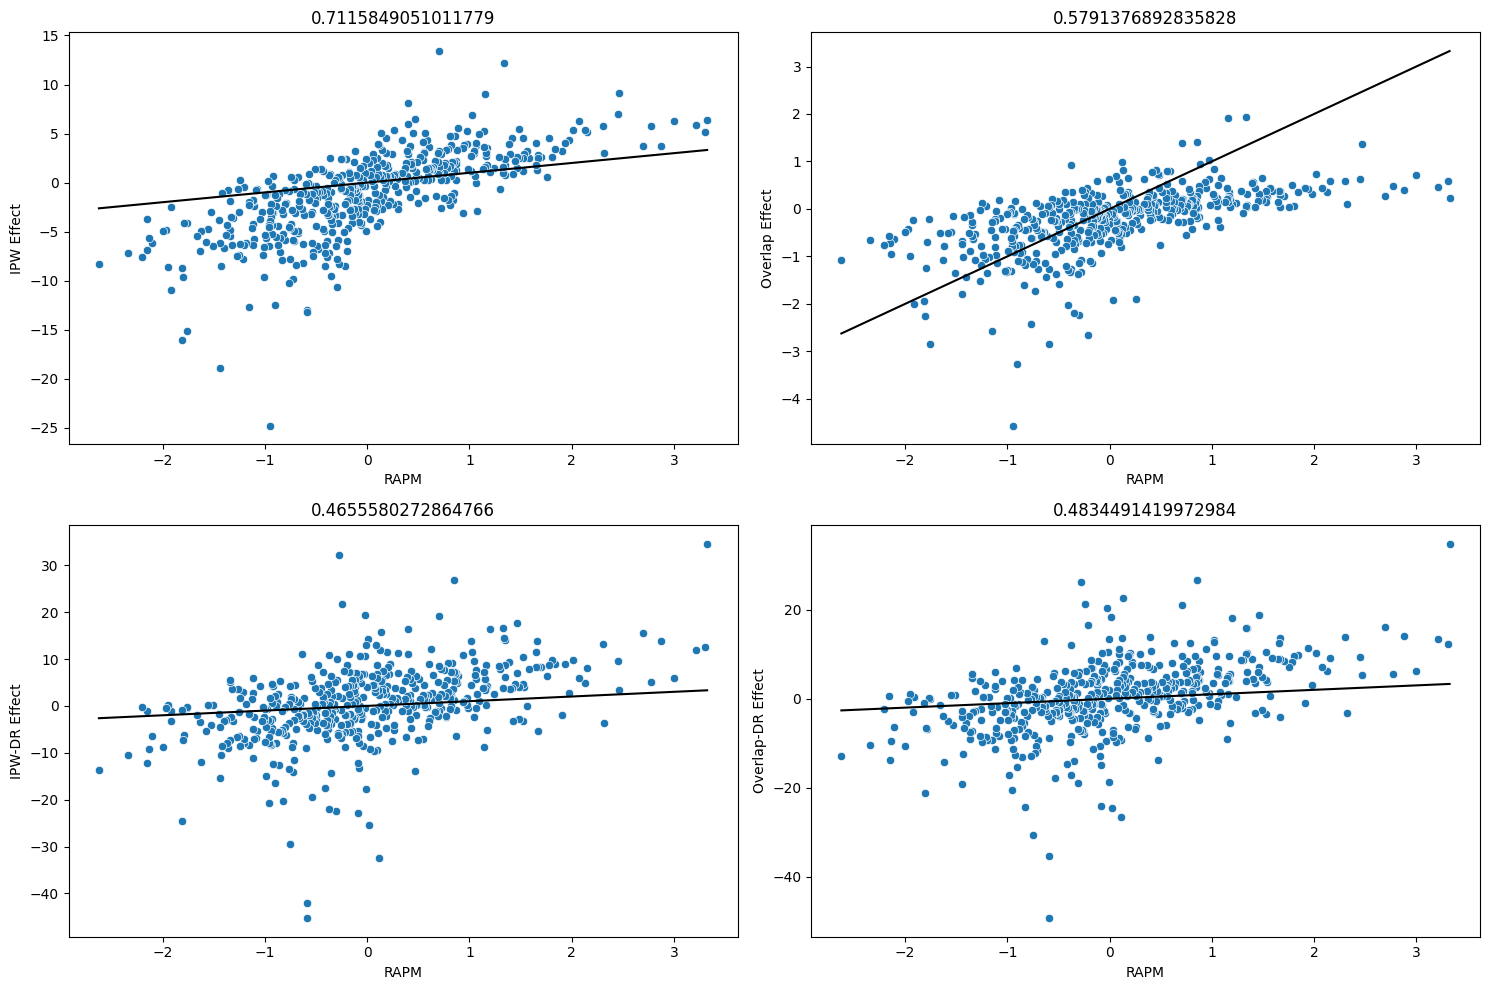

In [42]:
bools = results['Minutes'] >= 48

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(results[bools], x='RAPM', y='IPW Effect', ax=ax[0, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'IPW Effect']))
ax[0, 0].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')
sns.scatterplot(results[bools], x='RAPM', y='Overlap Effect', ax=ax[0, 1]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Overlap Effect']))
ax[0, 1].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')
sns.scatterplot(results[bools], x='RAPM', y='IPW-DR Effect', ax=ax[1, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'IPW-DR Effect']))
ax[1, 0].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')
sns.scatterplot(results[bools], x='RAPM', y='Overlap-DR Effect', ax=ax[1, 1]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Overlap-DR Effect']))
ax[1, 1].plot(results.loc[bools, 'RAPM'], results.loc[bools, 'RAPM'], 'k-')


fig.tight_layout()
fig.show()

Text(0.5, 1.0, '0.48280654236954884')

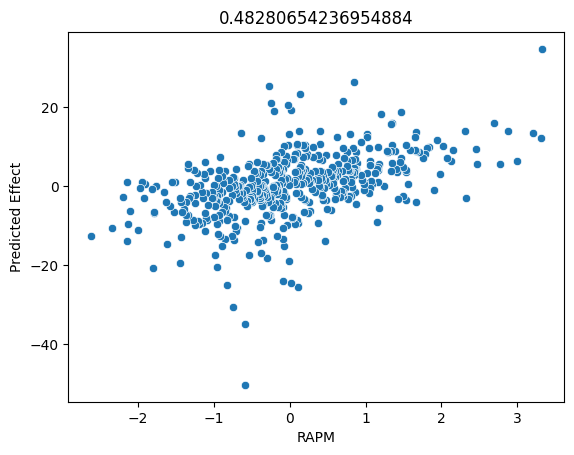

In [49]:
sns.scatterplot(results[bools], x='RAPM', y='Predicted Effect').set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Predicted Effect']))

In [44]:
print(results['Average Effect'].corr(results['RAPM']))


0.47317244196482916


In [45]:
results.sort_values(by='IPW-DR Effect', ascending=False)

,Player Name,RAPM,Average Effect,IPW Effect,Overlap Effect,IPW-DR Effect,Overlap-DR Effect,Minutes,Predicted Effect
Player ID,,,,,,,,,
203999,Nikola Jokic,3.325439,0.529107,6.372161,0.227238,34.621177,34.867960,2251.50,34.867534
1630270,Xavier Sneed,-0.280027,0.385417,-8.295487,-1.074675,32.154565,26.133733,67.38,25.481884
1630169,Tyrese Haliburton,0.852778,0.003356,-1.104886,-0.196310,26.792640,26.625064,1849.63,26.552036
1631303,Justin Minaya,-0.242944,0.384615,-3.264532,0.104370,21.816227,21.395024,82.19,21.067682
1626157,Karl-Anthony Towns,-0.025056,0.105202,0.982846,0.072522,19.319619,20.354235,873.97,20.521339
...,...,...,...,...,...,...,...,...,...
1627747,Caris LeVert,0.019774,0.022739,1.983042,-0.107761,-25.390602,-24.623189,2240.11,-24.509889
1631254,Kenneth Lofton Jr.,-0.751405,-0.261789,-7.760287,-1.163738,-29.464732,-30.553257,160.19,-30.742303
1629653,Devon Dotson,0.113183,0.213018,-1.270202,-0.794614,-32.366857,-26.495623,50.52,-25.698557


<Axes: xlabel='Min', ylabel='IPW-DR Effect'>

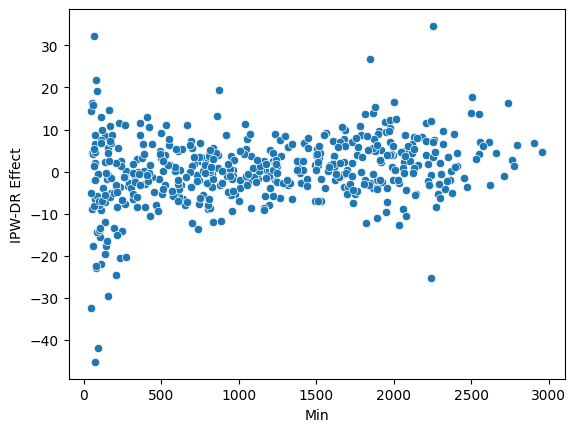

In [46]:
sns.scatterplot(results.loc[bools], x=box_scores.loc[bools, 'Min'], y='IPW-DR Effect')


# Analyze Importance of Features

Here, we investigate the importance of the input features into both the PM model and propensity models.

We will compute each feature's SHAP values.

In [47]:
# random forest
'''
n = 4

fig, ax = plt.subplots(n,n, figsize=(20, 15))
plr_ids = list(probs)

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id              = plr_ids[k]
    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])
    
    subset      = shap.utils.sample(plr_data, int(np.ceil(0.1 * len(plr_data))), random_state=1234) # use 10% of data as a mask
    explainer   = shap.Explainer(plr_model.predict, subset)
    shap_values = explainer(plr_data)

    graph = shap.plots.bar(shap_values, ax=ax[i, j], show=False)
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()
'''

'\nn = 4\n\nfig, ax = plt.subplots(n,n, figsize=(20, 15))\nplr_ids = list(probs)\n\nfor k in range(n**2):\n    i = k // n\n    j = k % n\n\n    plr_id              = plr_ids[k]\n    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])\n    \n    subset      = shap.utils.sample(plr_data, int(np.ceil(0.1 * len(plr_data))), random_state=1234) # use 10% of data as a mask\n    explainer   = shap.Explainer(plr_model.predict, subset)\n    shap_values = explainer(plr_data)\n\n    graph = shap.plots.bar(shap_values, ax=ax[i, j], show=False)\n    graph.set_title(plr_id_to_name[plr_id])\n\nfig.tight_layout()\nfig.show()\n'

C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\243993044.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_fig.show()
C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\243993044.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  opp_fig.show()
C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\243993044.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  margin_fig.show()
C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\243993044.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  time_fig.show()
C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\243993044.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  opp_fig.show()
C:\Users\Daniel\AppData\Local\Temp\ipykernel_16440\243993044.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  margin_fig.show()


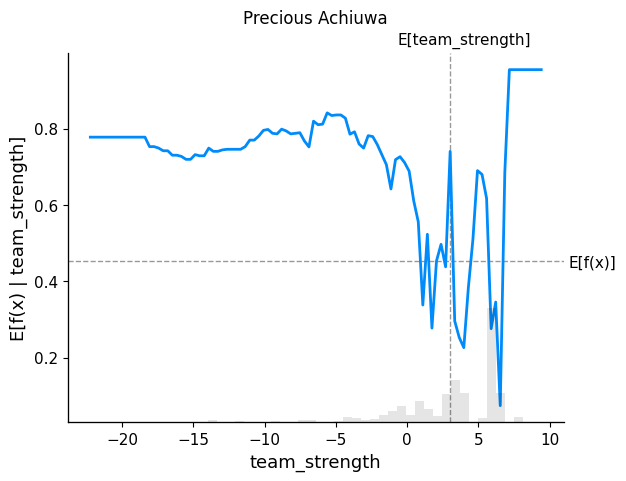

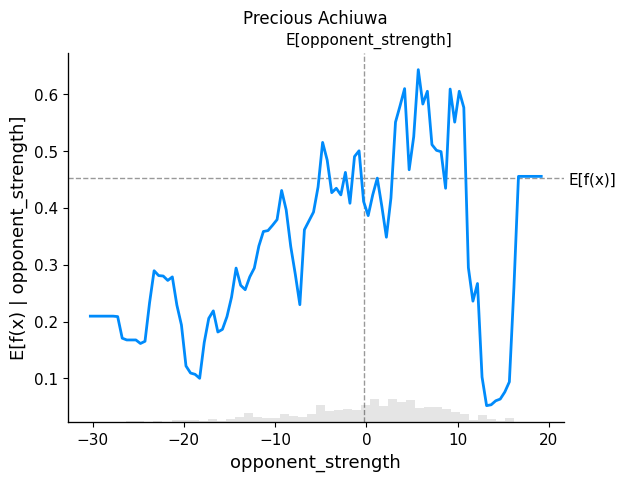

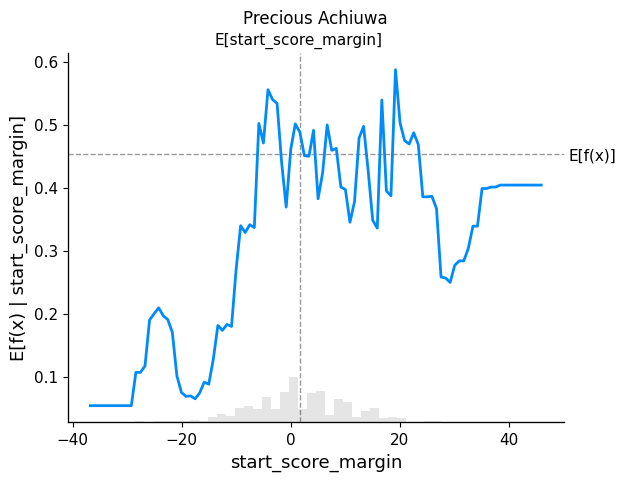

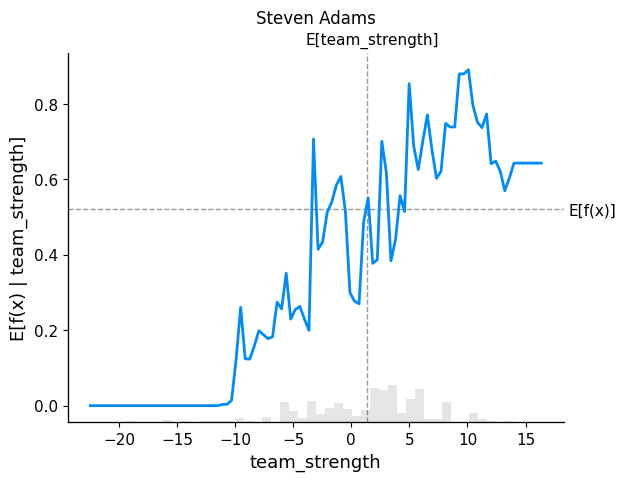

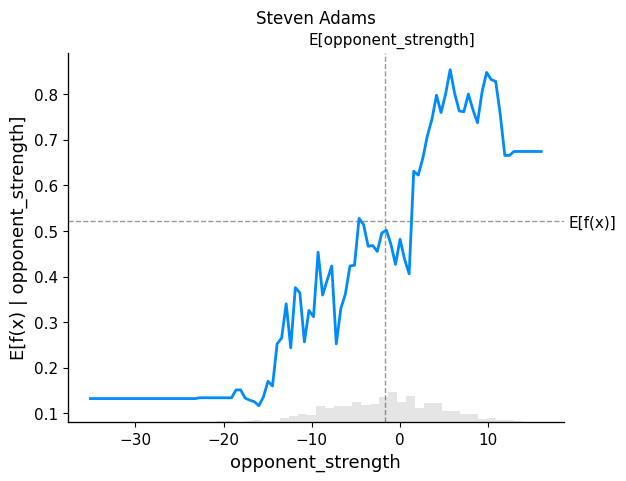

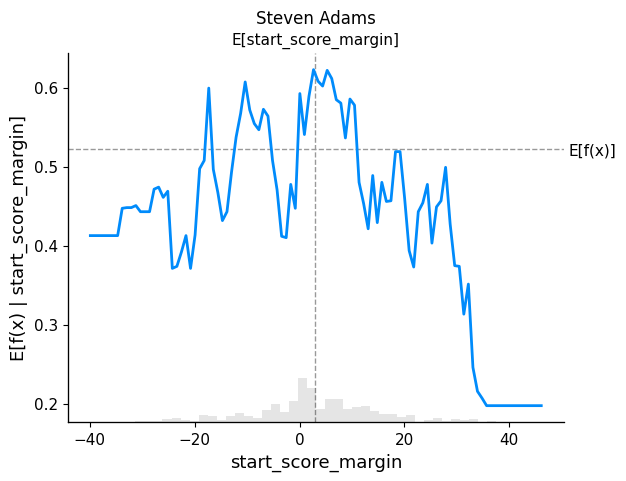

In [50]:
# random forest
plr_ids = list(prob_models)

for k in range(2):
    plr_id              = plr_ids[k]
    plr_model, plr_data = prob_models[plr_id].model, get_features(prob_models[plr_id].data)
    
    time_fig, time_ax = shap.partial_dependence_plot(
        "team_strength",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    time_ax.set_title(plr_id_to_name[plr_id])
    time_fig.show()
    
    opp_fig, opp_ax = shap.plots.partial_dependence(
        "opponent_strength",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    opp_ax.set_title(plr_id_to_name[plr_id])
    opp_fig.show()
    
    margin_fig, margin_ax = shap.plots.partial_dependence(
        "start_score_margin",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    margin_ax.set_title(plr_id_to_name[plr_id])
    margin_fig.show()

# Out-of-Sample Testing

We now compute the RMSE of our models, and compare it against the RAPM RMSE.

All data is from the 2023-2024 season.



In [51]:
rapm_model = RidgeCV( # Leave-One-Out CV based on MSE
    alphas=[10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000],
    fit_intercept=False
).fit(design, data['margin'], sample_weight=data['n_pos'])

In [52]:
oos_data: pd.DataFrame      = pd.read_csv('../../design_matrices/nba_2324_season_rapm_data.csv.gz', dtype={'game_id': str})
oos_players: dict[str, str] = pd.read_csv('../../data/nba_2324_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
oos_design                  = oos_data.drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)
oos_data                    = add_game_features(oos_data[['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin']])

combined_plrs = np.intersect1d(list(oos_players), list(plr_id_to_name))

In [53]:
# filter out stints when the game is decided
# drop iff start_time_elapsed >= 36 AND |start_score_margin| >= 20
# keep iff start_time_elapsed < 36 OR |start_score_margin| < 20
oos_ok_stints = (oos_data['start_time_left'] < 36) | (oos_data['start_score_margin'].abs() < 20)
oos_data = oos_data.loc[oos_ok_stints]
oos_design = oos_design.loc[oos_ok_stints]

# filter out data with low minute players
low_min_plrs = list(set(get_low_min_plrs(box_scores)).intersection(combined_plrs))

has_low_min_plr = oos_design[low_min_plrs].abs().sum(axis=1).astype(bool)

oos_design = oos_design.loc[~has_low_min_plr]
oos_data = oos_data.loc[~has_low_min_plr]

# filter out stints that contain new players
missing_from_2324 = list(set(plr_id_to_name) - set(combined_plrs))
missing_from_2223 = list(set(oos_players) - set(combined_plrs))
has_missing_player: pd.Series = oos_design[missing_from_2223].abs().sum(axis=1).astype(bool)

oos_design  = oos_design.loc[~has_missing_player].drop(missing_from_2223, axis=1)
oos_data    = oos_data.loc[~has_missing_player]

# add in players missing from 23/24 (they're just all zeros)
oos_design[missing_from_2324] = pd.DataFrame(
    data=np.zeros((len(oos_design.index), len(missing_from_2324)), dtype=np.int64),
    index=oos_design.index
)

# reorder the columns so the ordering matches the ordering of the 22/23 data
oos_design = oos_design[design.columns]

oos_design

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Now we write a function that will compute the RMSEs for a given player

## Evaluation over Players who Switched Teams

These players are of primary interest, since their environment is the one that changed the most.

In [54]:
team_data_2223: pd.DataFrame = CommonAllPlayers(season='2022', is_only_current_season=0).get_data_frames()[0].astype({'PERSON_ID': str}).set_index('PERSON_ID', drop=True)
team_data_2324: pd.DataFrame = CommonAllPlayers(season='2023', is_only_current_season=0).get_data_frames()[0].astype({'PERSON_ID': str}).set_index('PERSON_ID', drop=True)

diff_team_bools = team_data_2223.loc[combined_plrs, 'TEAM_ID'] != team_data_2324.loc[combined_plrs, 'TEAM_ID']

plrs_on_diff_team: pd.Index = team_data_2223.loc[combined_plrs][diff_team_bools].index

# some players aren't present in any stints (they were added before filtering). 
# filter them out because computing their RMSE doesn't make sense

valid_plrs = pd.Index(plr for plr in plrs_on_diff_team if oos_design[plr].any())

valid_plrs

Index(['101108', '1626145', '1626153', '1626158', '1626162', '1626166',
       '1626174', '1626179', '1626196', '1626220',
       ...
       '203552', '203915', '203925', '203926', '203933', '203935', '203967',
       '203994', '204001', '204060'],
      dtype='object', length=160)

In [65]:
def compute_rmse_data(
    plr_id: str, 
    *, 
    oos_data: pd.DataFrame = oos_data, 
    oos_design: pd.DataFrame = oos_design, 
    coefs: pd.DataFrame = results
) -> list:
    '''
    Compute a player's RMSE metrics. In order: `(plr_name, num_of_stints, rapm, ipw, overlap, ipw_dr, overlap_dr, forest, null)`.
    This is intended to be used for the creation of a dataset.

    This evaluates each of the coefficients against stints the player
    was present in.
    '''
    plr_in_stint: list[bool]    = oos_design[plr_id] != 0
    plr_true_target: pd.Series  = oos_data.loc[plr_in_stint, 'margin']
    plr_design: pd.DataFrame    = oos_design.loc[plr_in_stint]

    rapm_coefs          = coefs.loc[plr_design.columns, 'RAPM']
    ipw_coefs           = coefs.loc[plr_design.columns, 'IPW Effect']
    overlap_coefs       = coefs.loc[plr_design.columns, 'Overlap Effect']
    ipw_dr_coefs        = coefs.loc[plr_design.columns, 'IPW-DR Effect']
    overlap_dr_coefs    = coefs.loc[plr_design.columns, 'Overlap-DR Effect']
    pred_coefs          = coefs.loc[plr_design.columns, 'Predicted Effect']
    n_pos               = oos_data.loc[plr_in_stint, 'n_pos']

    return [
        plr_id_to_name[plr_id],
        len(plr_design),
        n_pos.sum(),
        round(rmse(plr_true_target, plr_design @ rapm_coefs,        sample_weight=n_pos), 2),
        round(rmse(plr_true_target, plr_design @ ipw_coefs,         sample_weight=n_pos), 2),
        round(rmse(plr_true_target, plr_design @ overlap_coefs,     sample_weight=n_pos), 2),
        round(rmse(plr_true_target, plr_design @ ipw_dr_coefs,      sample_weight=n_pos), 2),
        round(rmse(plr_true_target, plr_design @ overlap_dr_coefs,  sample_weight=n_pos), 2),
        round(rmse(plr_true_target, plr_design @ pred_coefs,        sample_weight=n_pos), 2),
        round(np.sqrt(np.dot(n_pos, plr_true_target**2) / n_pos.sum()), 2)
    ]

In [67]:
rmse_results = pd.DataFrame(
    data=[compute_rmse_data(plr) for plr in valid_plrs],
    index=valid_plrs,
    columns=['Player', 'Stints', 'Possessions', 'RAPM RMSE', 'IPW RMSE', 'Overlap RMSE', 'IPW-DR RMSE', 'Overlap-DR RMSE', 'Predicted RMSE', 'Null RMSE']
)

rmse_results['Best'] = rmse_results[['RAPM RMSE', 'IPW RMSE', 'Overlap RMSE', 'IPW-DR RMSE', 'Overlap-DR RMSE', 'Predicted RMSE', 'Null RMSE']].idxmin(axis=1)

In [ ]:
rmse_results.sort_values(by='Stints', ascending=False).to_csv('../../results/player_rmse.csv')

In [ ]:
display(rmse_results)

,Player,Stints,Possessions,RAPM RMSE,IPW RMSE,Overlap RMSE,IPW-DR RMSE,Overlap-DR RMSE,Null RMSE,Best
101108,Chris Paul,228,1647,48.26,49.26,48.33,52.94,52.34,48.39,RAPM RMSE
1626145,Tyus Jones,306,3276,39.60,41.36,39.49,42.25,42.47,39.44,Overlap RMSE
1626153,Delon Wright,67,449,48.23,49.69,48.73,45.02,44.59,48.65,Overlap-DR RMSE
1626158,Richaun Holmes,118,894,45.38,46.35,45.73,48.01,47.80,45.88,RAPM RMSE
1626162,Kelly Oubre Jr.,598,4978,44.80,45.46,44.91,48.70,48.85,45.01,RAPM RMSE
...,...,...,...,...,...,...,...,...,...,...
203935,Marcus Smart,246,1902,45.91,47.95,45.78,51.07,51.39,45.74,Overlap RMSE
203967,Dario Saric,141,1065,48.66,49.46,48.80,52.37,52.50,48.84,RAPM RMSE
203994,Jusuf Nurkic,644,5298,44.12,44.96,44.15,48.84,48.43,44.22,RAPM RMSE
204001,Kristaps Porzingis,520,4990,39.65,41.18,39.84,44.03,43.83,40.10,RAPM RMSE


In [68]:
rmse_results['Best'].value_counts()

Best
RAPM RMSE          71
Null RMSE          33
Overlap RMSE       29
IPW RMSE           16
Predicted RMSE      6
Overlap-DR RMSE     3
IPW-DR RMSE         2
Name: count, dtype: int64

In [77]:
rmse_results[
    ['RAPM RMSE', 'IPW RMSE', 'Overlap RMSE', 'IPW-DR RMSE', 'Overlap-DR RMSE', 'Predicted RMSE', 'Null RMSE']
].apply(lambda col: round(np.average(col, weights=rmse_results['Possessions']), 2))

RAPM RMSE          44.89
IPW RMSE           46.26
Overlap RMSE       44.92
IPW-DR RMSE        49.40
Overlap-DR RMSE    49.07
Predicted RMSE     49.07
Null RMSE          44.97
dtype: float64

In [70]:
rmse_results

,Player,Stints,Possessions,RAPM RMSE,IPW RMSE,Overlap RMSE,IPW-DR RMSE,Overlap-DR RMSE,Predicted RMSE,Null RMSE,Best
101108,Chris Paul,228,1647,48.26,49.26,48.33,52.94,52.34,52.32,48.39,RAPM RMSE
1626145,Tyus Jones,306,3276,39.60,41.36,39.49,42.25,42.47,42.58,39.44,Null RMSE
1626153,Delon Wright,67,449,48.23,49.69,48.73,45.02,44.59,44.54,48.65,Predicted RMSE
1626158,Richaun Holmes,118,894,45.38,46.35,45.73,48.01,47.80,47.84,45.88,RAPM RMSE
1626162,Kelly Oubre Jr.,598,4978,44.80,45.46,44.91,48.70,48.85,48.86,45.01,RAPM RMSE
...,...,...,...,...,...,...,...,...,...,...,...
203935,Marcus Smart,246,1902,45.91,47.95,45.78,51.07,51.39,51.51,45.74,Null RMSE
203967,Dario Saric,141,1065,48.66,49.46,48.80,52.37,52.50,52.66,48.84,RAPM RMSE
203994,Jusuf Nurkic,644,5298,44.12,44.96,44.15,48.84,48.43,48.41,44.22,RAPM RMSE
204001,Kristaps Porzingis,520,4990,39.65,41.18,39.84,44.03,43.83,43.84,40.10,RAPM RMSE


# Compare 2023 Metrics to 2023-2024 Box Score Stats

In [ ]:
box_stats_2324 = pd.read_csv('../../data/nba_2324_box_stats.csv')
oos_name_to_id = dict((plr_name, plr_id) for plr_id, plr_name in oos_players.items())

box_stats_2324['Player']   = box_stats_2324['Player'].apply(strip_accents)
box_stats_2324['PlayerID'] = box_stats_2324['Player'].apply(lambda name: oos_name_to_id[name])
box_stats_2324.drop_duplicates('Player', keep='first', inplace=True)

box_stats_2324.set_index('PlayerID', inplace=True)

In [ ]:
results.loc[valid_plrs]


,Player Name,RAPM,Average Effect,IPW Effect,Overlap Effect,IPW-DR Effect,Overlap-DR Effect,Minutes,Predicted Effect
101108,Chris Paul,0.873268,0.046885,1.272181,-0.179375,7.008516,8.525722,1730.94,8.761609
1626145,Tyus Jones,0.149894,-0.025198,2.025350,0.312718,-2.371928,-2.634951,1908.24,-2.756954
1626153,Delon Wright,1.237475,0.076923,1.473239,0.120614,2.468098,0.452481,1218.90,0.099356
1626158,Richaun Holmes,-1.272301,-0.205286,-7.447946,-1.526944,-6.616531,-8.337370,326.23,-8.629029
1626162,Kelly Oubre Jr.,-0.496374,-0.105426,-4.385784,-0.486388,-2.718640,-3.975243,1403.06,-4.052060
...,...,...,...,...,...,...,...,...,...
203935,Marcus Smart,0.148054,0.058163,3.278505,0.310868,3.885036,4.296195,1957.03,4.280611
203967,Dario Saric,0.174548,0.082508,1.734063,0.321475,3.379361,6.635339,713.89,7.366952
203994,Jusuf Nurkic,0.635900,0.098221,1.237678,0.295557,2.658529,3.637592,1119.27,3.780776
204001,Kristaps Porzingis,1.333455,0.114583,0.971021,0.048243,16.530930,15.803035,2000.91,15.839497


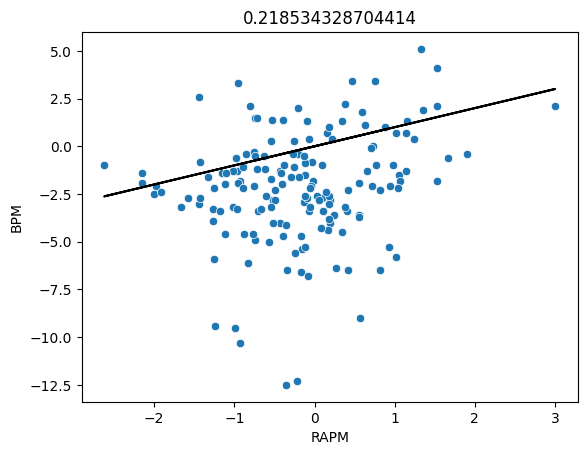

In [ ]:
axis = sns.scatterplot(x=results.loc[valid_plrs, 'RAPM'], y=box_stats_2324.loc[valid_plrs, 'BPM'])
axis.set_title(results.loc[valid_plrs, 'RAPM'].corr(box_stats_2324.loc[valid_plrs, 'BPM']))
axis.plot(results.loc[valid_plrs, 'RAPM'], results.loc[valid_plrs, 'RAPM'], 'k-')